In [ ]:
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git@newer-jax-verify

  Cloning https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git (to revision newer-jax-verify) to /tmp/pip-req-build-v0mssnr8
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git /tmp/pip-req-build-v0mssnr8
  Running command git checkout -b newer-jax-verify --track origin/newer-jax-verify
  Switched to a new branch 'newer-jax-verify'
  Branch 'newer-jax-verify' set up to track remote branch 'newer-jax-verify' from 'origin'.
  Resolved https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git to commit e3128f4da97353ade04bb5637277339d41687461
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/deepmind/einshape.git to /tmp/pip-install-87jn59v8/einshape_064a7fa0927d476cb875a577b5219585
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/einshape.git /tmp/pip-install-87jn59v8/einshape_064a7fa0927d476cb875a577b5219585
  Resolved https://github.com/d

# Instructions

Upload the weight files using the files panel in Colab's left sidebar.

Click the folder icon, then the upload button, and select your .pkl files.

They'll then be available when the script searches for controller files.

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
import pickle
import os
import functools
from google.colab import files

def upload_pickle_file():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Uploaded {filename}, {len(uploaded[filename])} bytes")
        return filename
    return None


# CROWN-based Controller Implementations #


In [ ]:
def relu_nn(params, inputs, v_max=7, omega_max=np.pi):
    for W, b in params[:-1]:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.maximum(outputs, 0)
    Wout, bout = params[-1]
    outputs = jnp.dot(inputs, Wout) + bout

    v = jnp.clip(outputs[0], -v_max, v_max)
    omega = jnp.clip(outputs[1], -omega_max, omega_max)

    return jnp.array([v, omega])

def linear_controller(params, inputs, v_max=7, omega_max=np.pi):
    W, b = params
    outputs = jnp.dot(inputs, W) + b

    v = jnp.clip(outputs[0], -v_max, v_max)
    omega = jnp.clip(outputs[1], -omega_max, omega_max)

    return jnp.array([v, omega])

# Gradient-based Controller Implementations #

In [ ]:
class GradientLinearController:
    def __init__(self, v_max=7, omega_max=np.pi):
        self.v_max = v_max
        self.omega_max = omega_max
        self.params = np.zeros(6)

    def __call__(self, state):
        norm_state = state / np.array([10.0, 10.0, np.pi])
        v_raw = np.dot(self.params[:3], norm_state)
        omega_raw = np.dot(self.params[3:], norm_state)
        v = np.clip(v_raw, -self.v_max, self.v_max)
        omega = np.clip(omega_raw, -self.omega_max, self.omega_max)
        return np.array([v, omega])

class GradientNNController:
    def __init__(self, v_max=7, omega_max=np.pi):
        self.v_max = v_max
        self.omega_max = omega_max
        self.layer_sizes = [3, 16, 32, 16, 2]

        self.params = []
        for i in range(1, len(self.layer_sizes)):
            in_dim = self.layer_sizes[i - 1]
            out_dim = self.layer_sizes[i]
            self.params.append((np.zeros((in_dim, out_dim)), np.zeros(out_dim)))

    def __call__(self, state):
        norm_state = state / np.array([10.0, 10.0, np.pi])
        x = norm_state
        for W, b in self.params[:-1]:
            z = np.dot(x, W) + b
            x = np.maximum(z, 0)

        W_final, b_final = self.params[-1]
        outputs = np.dot(x, W_final) + b_final

        v = np.clip(outputs[0], -self.v_max, self.v_max)
        omega = np.clip(outputs[1], -self.omega_max, self.omega_max)

        return np.array([v, omega])

    def set_params_flattened(self, flattened_params):
        idx = 0
        self.params = []

        for i in range(1, len(self.layer_sizes)):
            in_dim = self.layer_sizes[i - 1]
            out_dim = self.layer_sizes[i]

            W_size = in_dim * out_dim
            W = flattened_params[idx:idx + W_size].reshape(in_dim, out_dim)
            idx += W_size

            b_size = out_dim
            b = flattened_params[idx:idx + b_size]
            idx += b_size

            self.params.append((W, b))

# Dynamics Models #

In [ ]:
class UnicycleModel:
    def __init__(self):
        self.delta_t = 0.1

    def dynamics_step(self, xs, ut):
        """
        Unified dynamics step function that works with both NumPy and JAX arrays
        """
        if isinstance(xs, np.ndarray) and isinstance(ut, np.ndarray):
            # NumPy version for gradient-based controllers
            x, y, theta = xs
            v, omega = ut
            theta_new = theta + omega * self.delta_t
            x_new = x + v * np.cos(theta) * self.delta_t
            y_new = y + v * np.sin(theta) * self.delta_t
            return np.array([x_new, y_new, theta_new])
        else:
            # JAX version for CROWN controllers
            x, y, theta = xs
            v, omega = ut
            theta_new = theta + omega * self.delta_t
            x_new = x + v * jnp.cos(theta) * self.delta_t
            y_new = y + v * jnp.sin(theta) * self.delta_t
            return jnp.array([x_new, y_new, theta_new])

# Step Functions for Different Controllers #

In [ ]:
def step_nn(xt, params):
    ut = relu_nn(params, xt)
    return dyn.dynamics_step(xt, ut)

def step_linear(xt, params):
    ut = linear_controller(params, xt)
    return dyn.dynamics_step(xt, ut)

def step_gradient(state, controller):
    control = controller(state)
    return dyn.dynamics_step(state, control)

# Bounds and Reachable Set Computations    #

In [ ]:
class RectangularBound:
    """Compatible bound class for gradient-based methods"""
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

def compute_crown_reachable_set(initial_state_range, step_fn, params, num_steps):
    """Compute reachable sets using CROWN verification"""
    try:
        import jax_verify
        initial_state_bounds = jax_verify.IntervalBound(initial_state_range[:, 0], initial_state_range[:, 1])
        state_bounds = initial_state_bounds
        state_ranges = []

        for i in range(num_steps):
            next_state_bounds = jax_verify.backward_crown_bound_propagation(
                functools.partial(step_fn, params=params),
                state_bounds
            )
            state_ranges.append(next_state_bounds)
            state_bounds = next_state_bounds

        return state_ranges
    except ImportError:
        print("CROWN verification is not available. Please install jax-verify.")
        return None
    except Exception as e:
        print(f"Error computing CROWN reachable sets: {e}")
        return None

def compute_gradient_reachable_set(initial_state_range, controller, num_steps):
    """Compute reachable sets using gradient-based methods"""
    initial_state_bounds = RectangularBound(
        initial_state_range[:, 0].copy(),
        initial_state_range[:, 1].copy()
    )
    state_bounds = initial_state_bounds
    state_ranges = []

    for _ in range(num_steps):
        current_bounds = state_bounds
        next_lower = np.full(3, float('inf'))
        next_upper = np.full(3, -float('inf'))

        corners_x = [current_bounds.lower[0], current_bounds.upper[0]]
        corners_y = [current_bounds.lower[1], current_bounds.upper[1]]
        corners_theta = [current_bounds.lower[2], current_bounds.upper[2]]

        for x in corners_x:
            for y in corners_y:
                for theta in corners_theta:
                    state = np.array([x, y, theta])
                    next_state = step_gradient(state, controller)
                    next_lower = np.minimum(next_lower, next_state)
                    next_upper = np.maximum(next_upper, next_state)

        state_bounds = RectangularBound(next_lower, next_upper)
        state_ranges.append(state_bounds)

    return state_ranges

# Parameter Loading Functions   #

In [ ]:
def load_crown_params(filename):
    """Load CROWN-based controller parameters from a file."""
    try:
        with open(filename, 'rb') as f:
            numpy_params = pickle.load(f)

        # Determine if this is a linear controller or neural network based on structure
        if isinstance(numpy_params, tuple) and len(numpy_params) == 2:
            # This is likely a linear controller with (W, b) format
            jax_params = (jnp.array(numpy_params[0]), jnp.array(numpy_params[1]))
            controller_type = "crown_linear"
            print(f"Loaded CROWN linear controller parameters from {filename}")
        else:
            # This is likely a neural network with [(W1, b1), (W2, b2), ...] format
            jax_params = []
            for weights, biases in numpy_params:
                jax_weights = jnp.array(weights)
                jax_biases = jnp.array(biases)
                jax_params.append((jax_weights, jax_biases))
            controller_type = "crown_nn"
            print(f"Loaded CROWN neural network parameters from {filename}")

        return jax_params, controller_type
    except Exception as e:
        print(f"Error loading CROWN parameters: {e}")
        return None, None

def load_gradient_params(filename):
    """Load gradient-based controller parameters from a file."""
    try:
        with open(filename, 'rb') as f:
            params = pickle.load(f)

        # Determine controller type based on structure
        if isinstance(params, np.ndarray) and len(params) == 6:
            # This is a linear controller with 6 parameters
            controller = GradientLinearController()
            controller.params = params
            controller_type = "gradient_linear"
            print(f"Loaded gradient linear controller parameters from {filename}")
        else:
            # This is a neural network with flattened parameters
            controller = GradientNNController()
            controller.set_params_flattened(params)
            controller_type = "gradient_nn"
            print(f"Loaded gradient neural network parameters from {filename}")

        return controller, controller_type
    except Exception as e:
        print(f"Error loading gradient parameters: {e}")
        return None, None

def load_trained_params(filename):
    """Determine file type and load appropriate parameters"""
    if "crown" in filename.lower():
        return load_crown_params(filename)
    elif "gradient" in filename.lower():
        return load_gradient_params(filename)
    else:
        controller, controller_type = load_gradient_params(filename)
        if controller is not None:
            return controller, controller_type

        return load_crown_params(filename)

# Visualization Functions #

In [ ]:
def plot_multistep_samples_and_bounds(initial_state_range, controller_or_step_fn, num_steps, obstacles,
                                      bounds_list=None, controller_name="Controller", controller_type=None):
    """
    Enhanced unified plotting function for unicycle navigation visualization.
    Works with both CROWN and gradient-based controllers.
    """
    use_crown = controller_type is not None and controller_type.startswith("crown")

    if use_crown:
        # For CROWN controllers, use JAX's vmap
        xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000, 3))
        states = [xt]
        for _ in range(num_steps):
            xt1 = jax.vmap(controller_or_step_fn)(xt)
            states.append(xt1)
            xt = xt1
    else:
        # For gradient-based controllers
        xt = np.random.uniform(
            low=initial_state_range[:, 0],
            high=initial_state_range[:, 1],
            size=(1000, 3)
        )
        states = [xt]
        for _ in range(num_steps):
            next_states = np.zeros_like(xt)
            for i, x in enumerate(xt):
                next_states[i] = step_gradient(x, controller_or_step_fn)
            states.append(next_states)
            xt = next_states

    plt.figure(figsize=(14, 10))

    x_min, x_max = 0, 12
    y_min, y_max = 0, 12

    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1

    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    ax = plt.gca()
    ax.set_facecolor('white')

    for obs in obstacles:
        x, y, width, height = obs
        rect = Rectangle((x, y), width, height,
                         fill=True, facecolor='darkred', edgecolor='black',
                         linewidth=2, alpha=0.7, zorder=5)
        plt.gca().add_patch(rect)
        plt.text(x + width/2, y + height/2, 'OBSTACLE',
                ha='center', va='center',
                color='white', fontweight='bold', fontsize=14,
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'),
                zorder=15)

    if bounds_list is not None:
        for i, bounds in enumerate(bounds_list):
            lower = bounds.lower
            upper = bounds.upper

            color = plt.cm.plasma(i / len(bounds_list))
            alpha = 0.5 - (0.3 * i / len(bounds_list))

            rect = Rectangle((lower[0], lower[1]),
                            upper[0] - lower[0],
                            upper[1] - lower[1],
                            fill=True,
                            facecolor=color,
                            edgecolor='black',
                            linewidth=1,
                            alpha=alpha,
                            zorder=1)
            plt.gca().add_patch(rect)

    distinct_colors = []
    tab_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors)

    tab_colors_b = plt.cm.tab20b(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_b)

    tab_colors_c = plt.cm.tab20c(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_c)

    for i, state in enumerate(states):
        color = distinct_colors[i % len(distinct_colors)]

        plt.scatter(state[:, 0], state[:, 1], s=7, color=color, alpha=0.8,
                   label=f'Step {i}' if i % 3 == 0 or i == len(states)-1 else None,
                   zorder=10,
                   edgecolors='black', linewidths=0.3)

    init_x_mid = (initial_state_range[0, 0] + initial_state_range[0, 1]) / 2
    init_y_mid = (initial_state_range[1, 0] + initial_state_range[1, 1]) / 2
    init_width = initial_state_range[0, 1] - initial_state_range[0, 0]
    init_height = initial_state_range[1, 1] - initial_state_range[1, 0]

    init_rect = Rectangle((initial_state_range[0, 0], initial_state_range[1, 0]),
                         init_width, init_height,
                         fill=True, facecolor='red', edgecolor='black',
                         linewidth=2, alpha=0.3, zorder=5)
    plt.gca().add_patch(init_rect)
    plt.text(init_x_mid, init_y_mid, 'START',
             ha='center', va='center',
             color='white', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=15)

    goal_x, goal_y = 7, 7
    plt.scatter(goal_x, goal_y, s=400, marker='*', color='gold',
               edgecolor='black', linewidth=1.5, zorder=20)
    plt.text(goal_x, goal_y - 0.5, 'GOAL',
             ha='center', va='center',
             color='black', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='green', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=20)

    plt.xlabel('X Position', fontsize=20)
    plt.ylabel('Y Position', fontsize=20)
    plt.title(f"Unicycle Controller: {controller_name}", fontsize=24, pad=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.grid(True, linestyle='--', alpha=0.6, zorder=0)

    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor=plt.cm.plasma(0.5), edgecolor='black', alpha=0.5, label='Reachable Sets'),
        Rectangle((0, 0), 1, 1, facecolor='red', edgecolor='black', alpha=0.3, label='Initial State Region'),
        Rectangle((0, 0), 1, 1, facecolor='darkred', edgecolor='black', alpha=0.7, label='Obstacles'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markersize=18, label='Goal Position')
    ]

    ncol = min(3, max(1, len(legend_elements) // 5))
    plt.legend(handles=legend_elements, loc='upper left', fontsize=16, ncol=ncol,
              framealpha=0.8, edgecolor='black')

    plt.tight_layout()
    filename = f'unicycle_navigation_{controller_name.replace(" ", "_").lower()}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved plot as {filename}")
    plt.show()

def plot_loss_history(loss_history, method=""):
    """Plot the training loss history."""
    plt.figure(figsize=(12, 6))

    plt.plot(loss_history, color='#1f77b4', linewidth=2, alpha=0.8)

    window_size = min(50, len(loss_history) // 10)
    if window_size > 0:
        smoothed_loss = np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(loss_history)), smoothed_loss,
                color='#ff7f0e', linewidth=3, label=f'Moving Avg (window={window_size})')

    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title(f'Training Loss Over Time ({method})', fontsize=16, pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)

    if len(loss_history) > 0:
        plt.annotate(f'Initial loss: {loss_history[0]:.2f}',
                    xy=(0, loss_history[0]),
                    xytext=(len(loss_history)*0.05, loss_history[0]*1.1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=12)

        plt.annotate(f'Final loss: {loss_history[-1]:.2f}',
                    xy=(len(loss_history)-1, loss_history[-1]),
                    xytext=(len(loss_history)*0.8, loss_history[-1]*1.5),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=12)

    plt.legend(fontsize=12)

    if min(loss_history) > 0:
        plt.yscale('log')
        plt.title(f'Training Loss Over Time ({method}) - Log Scale', fontsize=16, pad=20)

    plt.tight_layout()
    plt.savefig(f'training_loss_{method.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main Function #

In [ ]:
dyn = UnicycleModel()
initial_state_range = np.array([[0, 1],
                               [0, 1],
                               [0, np.pi/6]])

obstacles = [
    [2.0, 4.0, 1.0, 1.0],
    [7.75, 1.75, 1.0, 1.0]
]

def main():
    """Unified main function to run all controller types and verification methods"""
    print("Unified Controller Verification Tool")
    print("------------------------------------")

    all_files = [f for f in os.listdir() if f.endswith('.pkl')]
    crown_linear_files = [f for f in all_files if 'crown' in f.lower() and 'linear' in f.lower()]
    crown_nn_files = [f for f in all_files if 'crown' in f.lower() and ('nn' in f.lower() or 'neural' in f.lower())]
    gradient_linear_files = [f for f in all_files if 'gradient' in f.lower() and 'linear' in f.lower()]
    gradient_nn_files = [f for f in all_files if 'gradient' in f.lower() and ('nn' in f.lower() or 'neural' in f.lower())]

    print(f"\nFound {len(crown_linear_files)} CROWN linear controllers")
    print(f"Found {len(crown_nn_files)} CROWN neural network controllers")
    print(f"Found {len(gradient_linear_files)} gradient linear controllers")
    print(f"Found {len(gradient_nn_files)} gradient neural network controllers")

    print("\nOptions:")
    print("1. Run CROWN linear controller")
    print("2. Run CROWN neural network controller")
    print("3. Run gradient linear controller")
    print("4. Run gradient neural network controller")
    print("5. Run ALL controllers")

    try:
        choice = int(input("Enter your choice (1-5): "))

        if choice == 5:
            print("\nRunning ALL controller types...")
            run_all_controllers(crown_linear_files, crown_nn_files, gradient_linear_files, gradient_nn_files)
        elif choice == 1:
            if crown_linear_files:
                run_crown_verification(crown_linear_files[0], force_type="crown_linear")
            else:
                print("\nNo CROWN linear controller found. Please upload one.")
        elif choice == 2:
            if crown_nn_files:
                run_crown_verification(crown_nn_files[0], force_type="crown_nn")
            else:
                print("\nNo CROWN neural network controller found. Please upload one.")
        elif choice == 3:
            if gradient_linear_files:
                run_gradient_verification(gradient_linear_files[0], force_type="gradient_linear")
            else:
                print("\nNo gradient linear controller found. Please upload one.")
        elif choice == 4:
            if gradient_nn_files:
                run_gradient_verification(gradient_nn_files[0], force_type="gradient_nn")
            else:
                print("\nNo gradient neural network controller found. Please upload one.")
        else:
            print("Invalid choice. Exiting.")
    except Exception as e:
        print(f"Error: {e}")
        print("Invalid input. Exiting.")

def run_all_controllers(crown_linear_files, crown_nn_files, gradient_linear_files, gradient_nn_files):
    """Run all available controller types and generate their plots"""
    # Run CROWN linear controller
    if crown_linear_files:
        print("\nRunning CROWN linear controller...")
        run_crown_verification(crown_linear_files[0], force_type="crown_linear")
    else:
        print("\nNo CROWN linear controller found.")

    # Run CROWN neural network controller
    if crown_nn_files:
        print("\nRunning CROWN neural network controller...")
        run_crown_verification(crown_nn_files[0], force_type="crown_nn")
    else:
        print("\nNo CROWN neural network controller found.")

    # Run gradient linear controller
    if gradient_linear_files:
        print("\nRunning gradient linear controller...")
        run_gradient_verification(gradient_linear_files[0], force_type="gradient_linear")
    else:
        print("\nNo gradient linear controller found.")

    # Run gradient neural network controller
    if gradient_nn_files:
        print("\nRunning gradient neural network controller...")
        run_gradient_verification(gradient_nn_files[0], force_type="gradient_nn")
    else:
        print("\nNo gradient neural network controller found.")

    print("\nAll controller types processed.")

def run_crown_verification(pickle_path=None, force_type=None):
    """Run CROWN-based controller verification"""
    print("\nRunning CROWN-based verification...")

    if pickle_path is None:
        pickle_files = [f for f in os.listdir() if f.endswith('.pkl') and ('crown' in f.lower())]

        if pickle_files:
            print("Found CROWN-based controller files in current directory:")
            for i, file in enumerate(pickle_files):
                print(f"{i+1}. {file}")

            try:
                choice = int(input(f"Enter the number of the file to use (1-{len(pickle_files)}), or 0 to upload a new file: "))
                if 1 <= choice <= len(pickle_files):
                    pickle_path = pickle_files[choice-1]
                else:
                    print("Uploading new file...")
                    pickle_path = upload_pickle_file()
            except:
                print("Invalid input, uploading new file...")
                pickle_path = upload_pickle_file()

        else:
            print("No CROWN controller files found in the current directory. Please upload one.")
            pickle_path = upload_pickle_file()

    if not pickle_path:
        print("No pickle file provided. Exiting CROWN verification.")
        return

    trained_params, controller_type = load_crown_params(pickle_path)

    if trained_params is None:
        print("Failed to load parameters. Exiting CROWN verification.")
        return

    if force_type is not None:
        controller_type = force_type

    if controller_type == "crown_linear":
        step_fn = step_linear
        controller_name = "CROWN Linear"
        print("Using CROWN linear controller step function")
    else:
        step_fn = step_nn
        controller_name = "CROWN Neural Network"
        print("Using CROWN neural network controller step function")

    print("Computing reachable sets using CROWN-verified controller...")
    num_steps = 24
    output_ranges = compute_crown_reachable_set(initial_state_range, step_fn, trained_params, num_steps)

    if output_ranges is None:
        print("Failed to compute reachable sets.")
        return

    print("Plotting reachable sets and sample trajectories...")
    plot_multistep_samples_and_bounds(
        initial_state_range,
        functools.partial(step_fn, params=trained_params),
        num_steps,
        obstacles,
        bounds_list=output_ranges,
        controller_name=controller_name,
        controller_type=controller_type
    )

def run_gradient_verification(pickle_path=None, force_type=None):
    """Run gradient-based controller verification"""
    print("\nRunning gradient-based verification...")

    if pickle_path is None:
        pickle_files = [f for f in os.listdir() if f.endswith('.pkl') and (f.startswith('gradient_') or 'gradient' in f)]

        if pickle_files:
            print("Found gradient-based controller files in current directory:")
            for i, file in enumerate(pickle_files):
                print(f"{i+1}. {file}")

            try:
                choice = int(input(f"Enter the number of the file to use (1-{len(pickle_files)}), or 0 to upload a new file: "))
                if 1 <= choice <= len(pickle_files):
                    pickle_path = pickle_files[choice-1]
                else:
                    print("Uploading new file...")
                    pickle_path = upload_pickle_file()
            except:
                print("Invalid input, uploading new file...")
                pickle_path = upload_pickle_file()

        else:
            print("No gradient controller files found in the current directory. Please upload one.")
            pickle_path = upload_pickle_file()

    if not pickle_path:
        print("No pickle file provided. Exiting gradient verification.")
        return

    controller, controller_type = load_gradient_params(pickle_path)

    if controller is None:
        print("Failed to load parameters. Exiting gradient verification.")
        return

    if force_type is not None:
        controller_type = force_type

    if controller_type == "gradient_linear":
        controller_name = "Gradient Linear"
    else:
        controller_name = "Gradient Neural Network"

    print("Computing reachable sets using gradient-based controller...")
    num_steps = 24
    output_ranges = compute_gradient_reachable_set(initial_state_range, controller, num_steps)

    print("Plotting reachable sets and sample trajectories...")
    plot_multistep_samples_and_bounds(
        initial_state_range,
        controller,
        num_steps,
        obstacles,
        bounds_list=output_ranges,
        controller_name=controller_name
    )

# Execute Code

Unified Controller Verification Tool
------------------------------------

Found 1 CROWN linear controllers
Found 1 CROWN neural network controllers
Found 1 gradient linear controllers
Found 1 gradient neural network controllers

Options:
1. Run CROWN linear controller
2. Run CROWN neural network controller
3. Run gradient linear controller
4. Run gradient neural network controller
5. Run ALL controllers
Enter your choice (1-5): 5

Running ALL controller types...

Running CROWN linear controller...

Running CROWN-based verification...
Loaded CROWN linear controller parameters from crown_linear.pkl
Using CROWN linear controller step function
Computing reachable sets using CROWN-verified controller...
Plotting reachable sets and sample trajectories...
Saved plot as unicycle_navigation_crown_linear.png


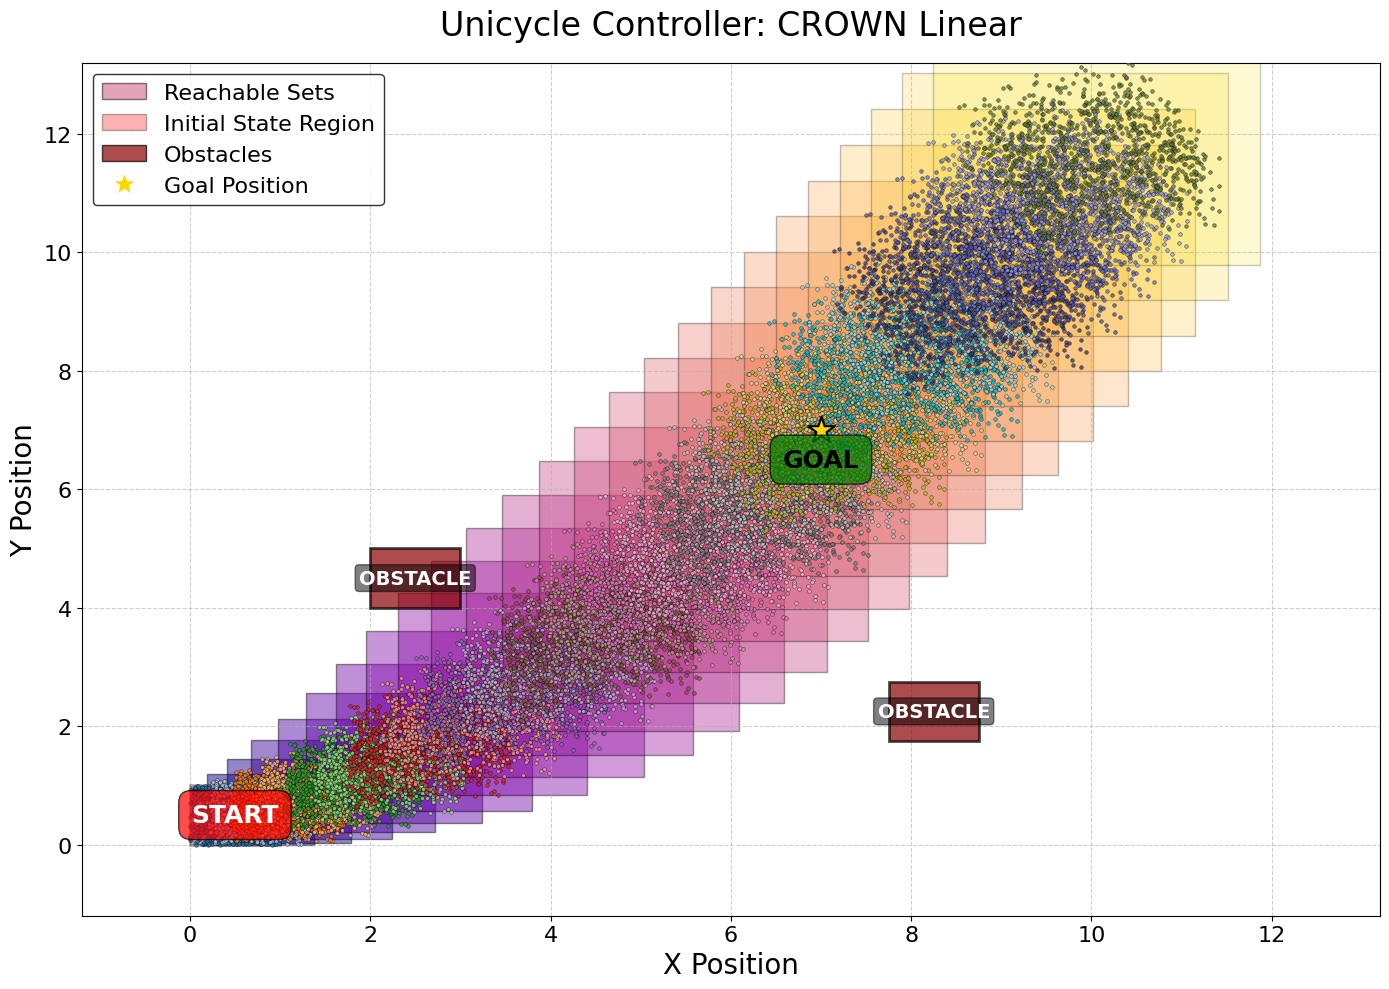


Running CROWN neural network controller...

Running CROWN-based verification...
Loaded CROWN neural network parameters from crown_nn.pkl
Using CROWN neural network controller step function
Computing reachable sets using CROWN-verified controller...
Plotting reachable sets and sample trajectories...
Saved plot as unicycle_navigation_crown_neural_network.png


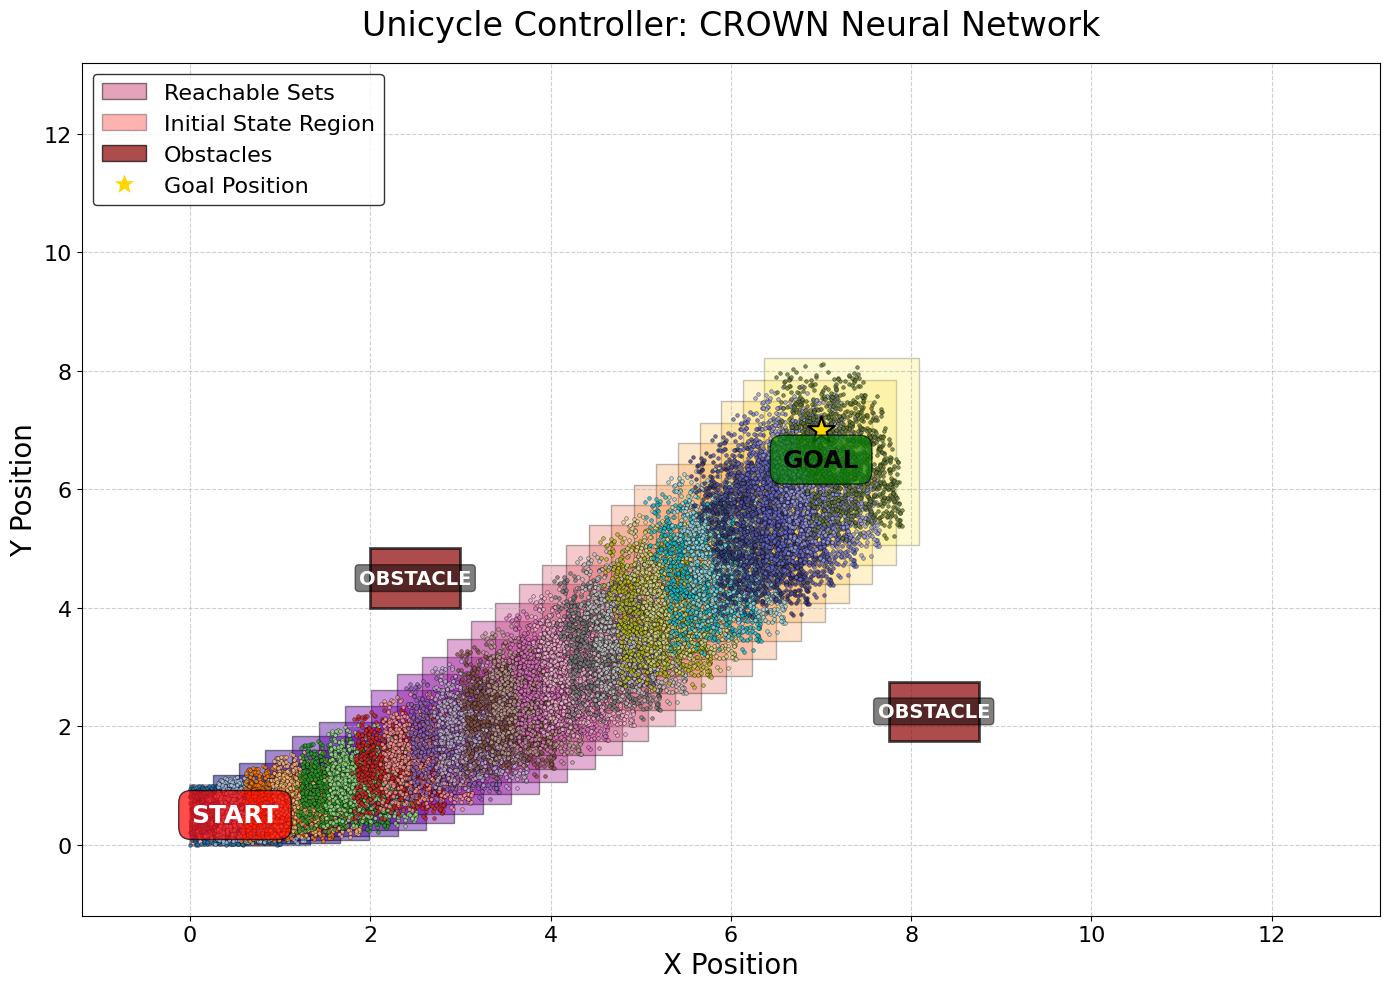


Running gradient linear controller...

Running gradient-based verification...
Loaded gradient linear controller parameters from gradient_linear.pkl
Computing reachable sets using gradient-based controller...
Plotting reachable sets and sample trajectories...
Saved plot as unicycle_navigation_gradient_linear.png


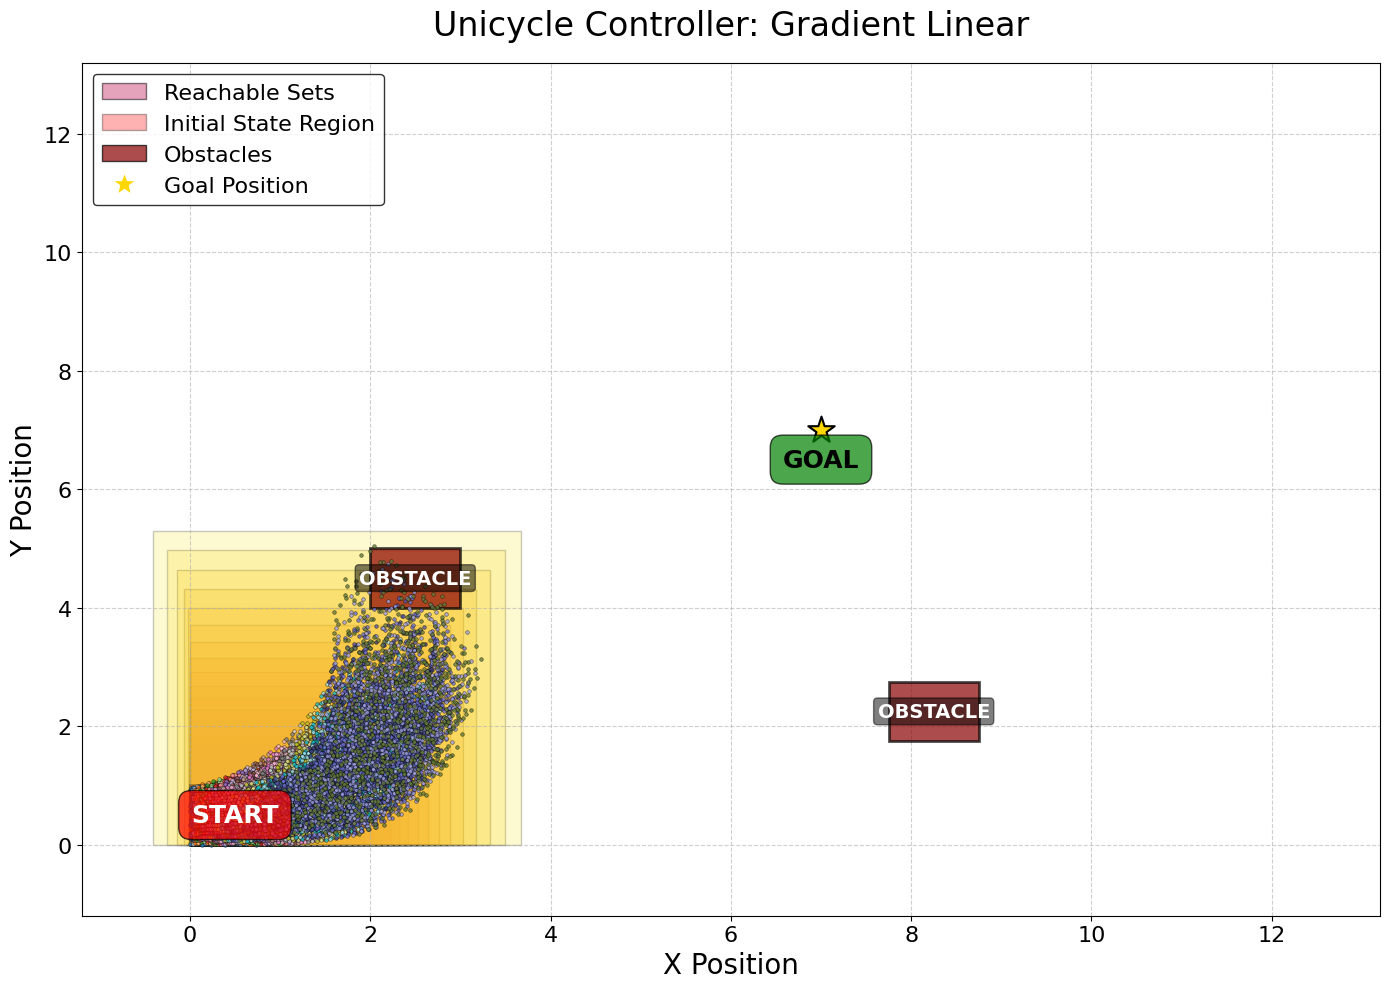


Running gradient neural network controller...

Running gradient-based verification...
Loaded gradient neural network parameters from gradient_nn.pkl
Computing reachable sets using gradient-based controller...
Plotting reachable sets and sample trajectories...
Saved plot as unicycle_navigation_gradient_neural_network.png


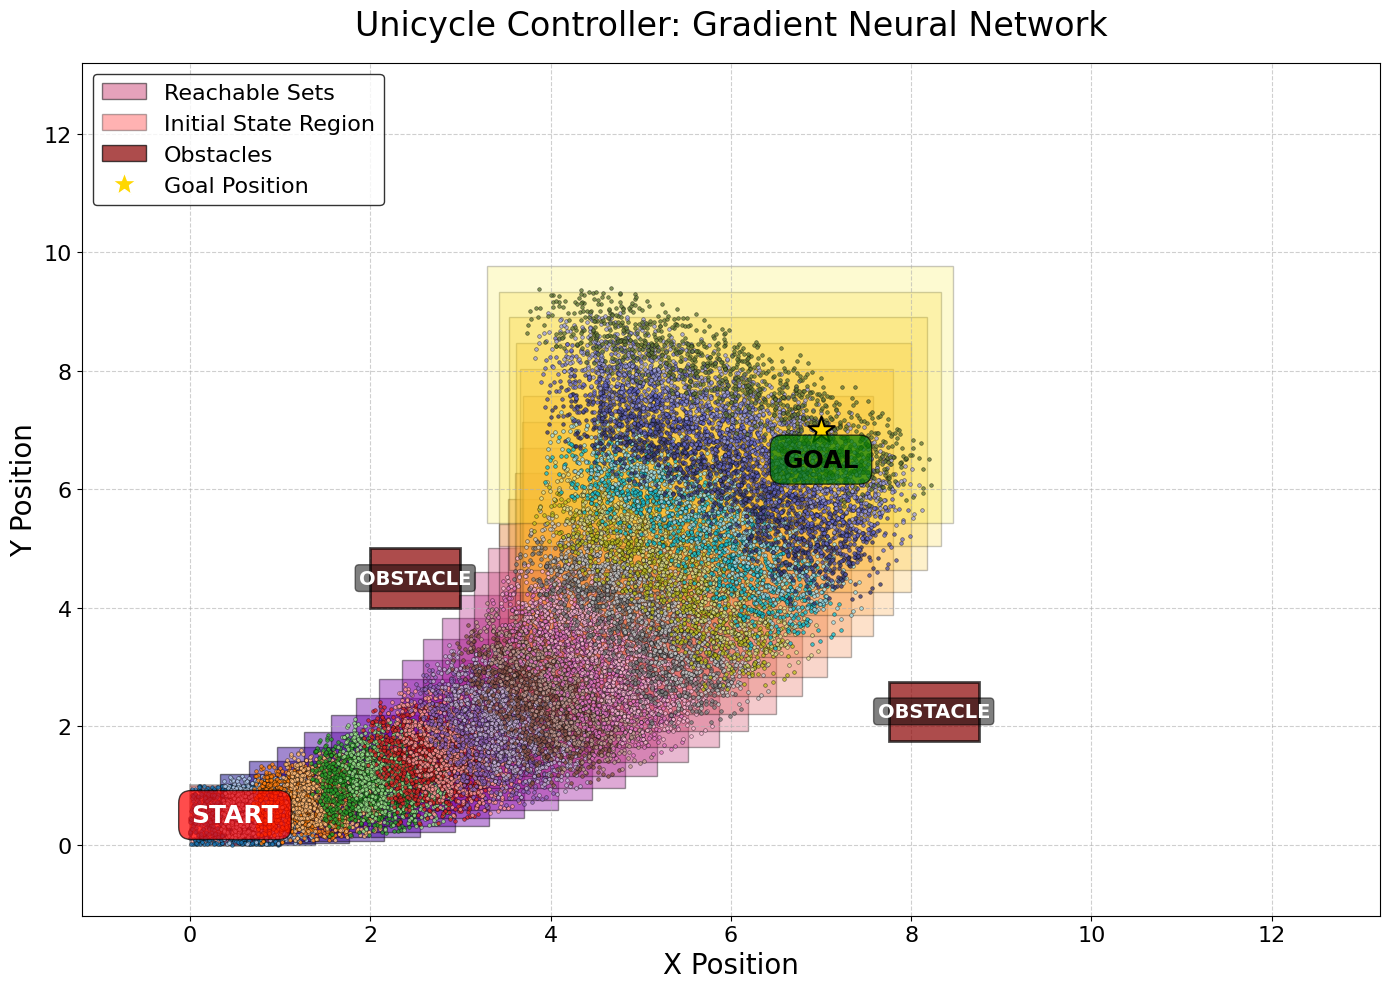


All controller types processed.


In [ ]:
main()